In [ ]:
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

IMAGE_SIZE = 128
BATCH_SIZE = 16
CHANNELS = 3

In [ ]:
# import os
# import shutil

# # Path direktori yang ingin dikosongkan
# dir_path = '/content'

# # Fungsi untuk menghapus semua file dan folder kecuali drive di dalam direktori
# def empty_directory_except_drive(directory):
#     for filename in os.listdir(directory):
#         file_path = os.path.join(directory, filename)
#         try:
#             if file_path != '/content/drive':
#                 if os.path.isfile(file_path) or os.path.islink(file_path):
#                     os.unlink(file_path)
#                 elif os.path.isdir(file_path):
#                     shutil.rmtree(file_path)
#         except Exception as e:
#             print(f"Failed to delete {file_path}. Reason: {e}")

# # Memanggil fungsi untuk mengosongkan direktori kecuali drive
# empty_directory_except_drive(dir_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file in your Google Drive
zip_file_path = '/content/drive/MyDrive/KidneyDisease/CT-KIDNEY-DATASET-Reduced.zip'

# Directory to extract the contents of the ZIP file
extracted_dir_path = '/content/dataset/'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Extracted Files:", extracted_files)

extracted_dir_path = "/content/dataset/CT-KIDNEY-DATASET-Reduced"
dataset = tf.keras.utils.image_dataset_from_directory(
    extracted_dir_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted Files: ['__MACOSX', 'CT-KIDNEY-DATASET-Reduced']
Found 2719 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

# Hitung jumlah sampel per kelas
class_samples_count = {}
total_samples = 0

for class_name in class_names:
    samples_count = sum(1 for _ in os.listdir(os.path.join(extracted_dir_path, class_name)))
    class_samples_count[class_name] = samples_count
    total_samples += samples_count

# Tampilkan jumlah sampel per kelas
for class_name, count in class_samples_count.items():
    print(f"Class: {class_name}, Number of samples: {count}")

# Tampilkan jumlah total sampel
print(f"Total number of samples: {total_samples}")

Class: Cyst, Number of samples: 608
Class: Normal, Number of samples: 878
Class: Stone, Number of samples: 615
Class: Tumor, Number of samples: 622
Total number of samples: 2723


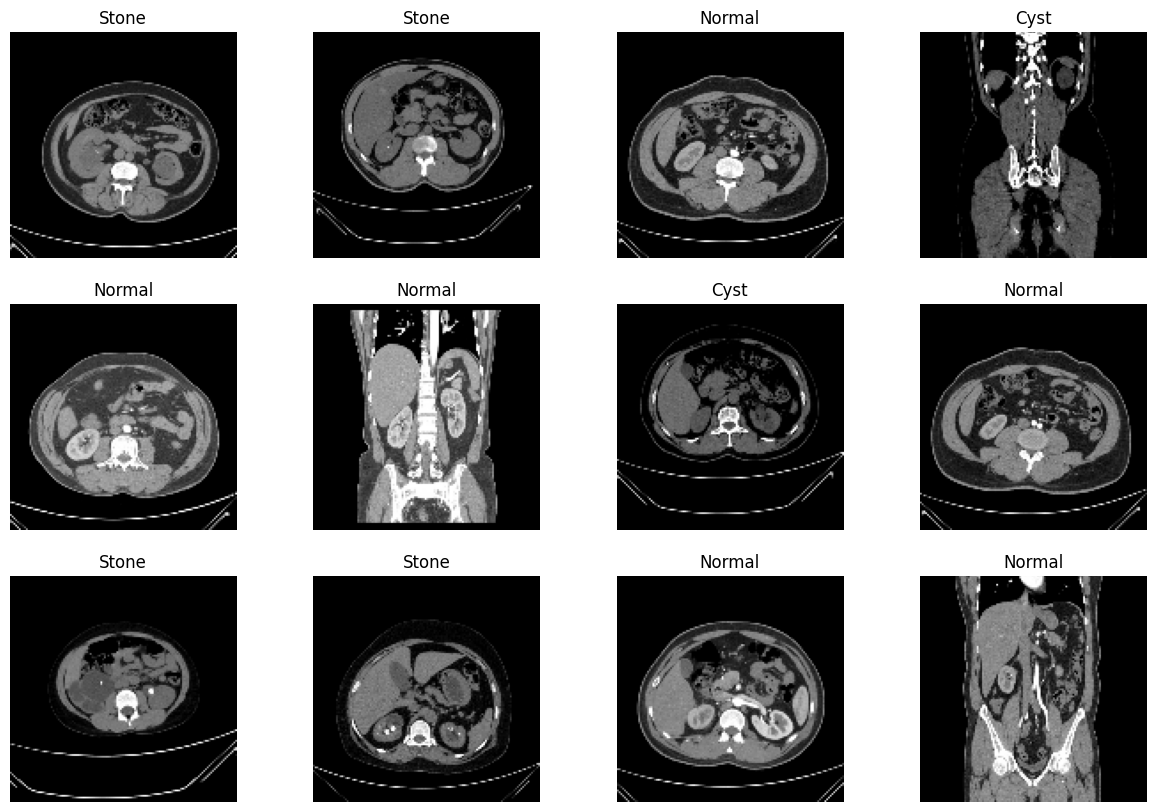

In [ ]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take (1):
    for i in range(12) :
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to convert labels to one-hot encoded vectors
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

# Build CNN model
def build_cnn_model(input_shape):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu')
    ])
    return model

# Build ELM model
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, hidden_size)
        self.bias = np.random.randn(hidden_size)
        self.beta = None

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def train(self, X, Y):
        H = self._sigmoid(np.dot(X, self.weights) + self.bias)
        self.beta = np.dot(np.linalg.pinv(H), Y)

    def predict(self, X):
        H = self._sigmoid(np.dot(X, self.weights) + self.bias)
        Y_pred = np.dot(H, self.beta)
        return Y_pred

In [ ]:
# Prepare data
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

# Prepare dataset for CNN
dataset_cnn = tf.keras.utils.image_dataset_from_directory(
    extracted_dir_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Normalisasi dan Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Pembagian dataset untuk validasi
)

# Memuat dan Memisahkan Data
train_generator = train_datagen.flow_from_directory(
    extracted_dir_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Bagian training dataset
)

validation_generator = train_datagen.flow_from_directory(
    extracted_dir_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Bagian validation dataset
)

# Tes Data
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi nilai piksel
test_generator = test_datagen.flow_from_directory(
    extracted_dir_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Untuk menjamin konsistensi pengujian
)

# Extract features using CNN
cnn_model = build_cnn_model(input_shape)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get features from CNN model
features = []
labels = []
for image_batch, label_batch in dataset_cnn:
    features_batch = cnn_model.predict(image_batch)
    features.extend(features_batch)
    labels.extend(label_batch.numpy())

features = np.array(features)
labels = np.array(labels)
labels_one_hot = one_hot_encode(labels, num_classes)

Found 2719 files belonging to 4 classes.
Found 2177 images belonging to 4 classes.
Found 542 images belonging to 4 classes.
Found 2719 images belonging to 4 classes.
1/1 [==============================] - 0s 191ms/step


In [ ]:
from sklearn.model_selection import train_test_split

# Pemisahan dataset untuk ELM
train_features_cnn, test_features_cnn, train_labels, test_labels = train_test_split(features, labels_one_hot, test_size=0.2, random_state=42)

# Buat dan latih model ELM
input_size_elm = train_features_cnn.shape[1]
hidden_size_elm = 300  # Customizable hidden size
output_size_elm = num_classes

elm = ELM(input_size_elm, hidden_size_elm, output_size_elm)
elm.train(train_features_cnn, train_labels)

# Evaluasi model ELM
predictions_elm = elm.predict(test_features_cnn)
accuracy_elm = np.mean(np.argmax(predictions_elm, axis=1) == np.argmax(test_labels, axis=1))
print("ELM Test Accuracy:", accuracy_elm)


ELM Test Accuracy: 0.9669117647058824


<ipython-input-38-7ce288a4a557>:36: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


1/1 [==============================] - 0s 20ms/step


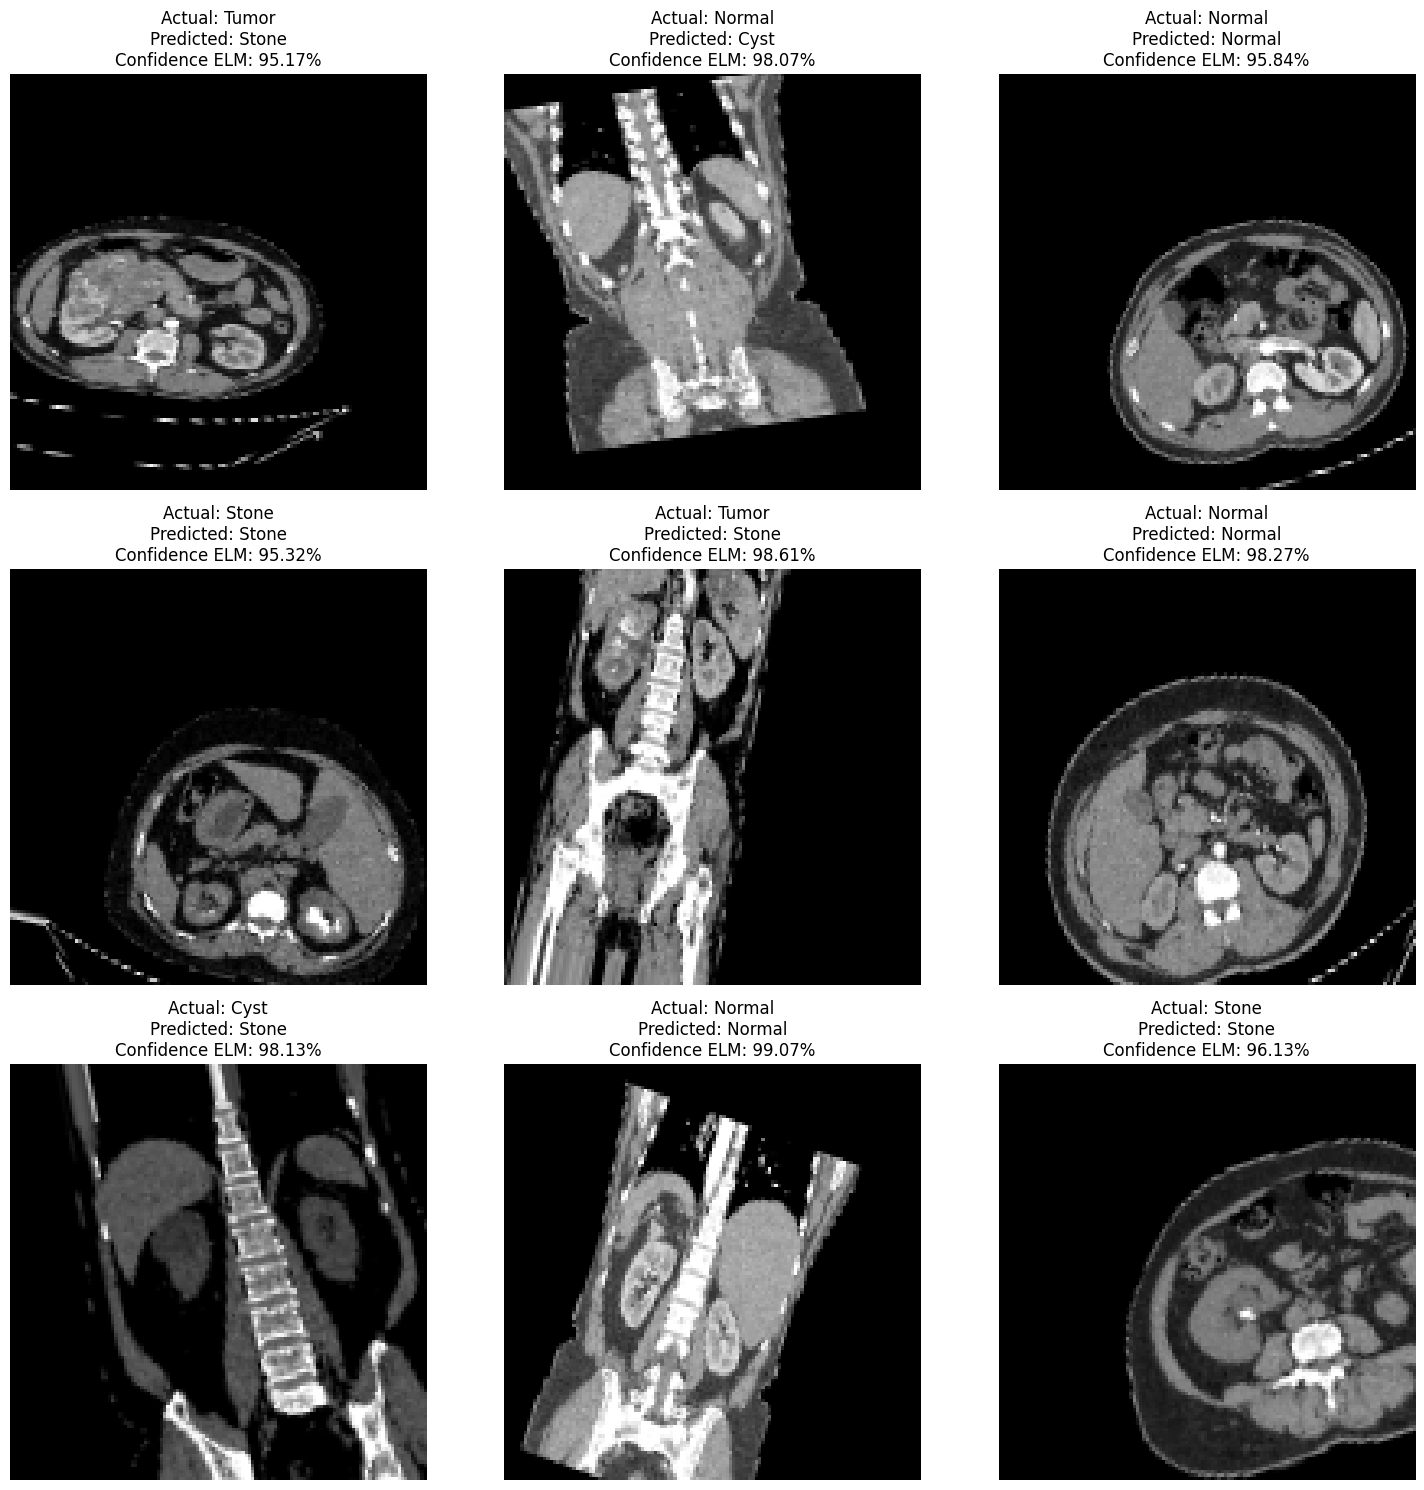

In [ ]:
# Sesuaikan dan perbarui visualisasi hasil menggunakan ELM
plt.figure(figsize=(15, 15))

# Mengambil beberapa batch dari train_generator
num_batches = 3
images_per_batch = 3

for i, (images, labels) in enumerate(train_generator):
    if i >= num_batches:  # Mengambil sejumlah batch tertentu
        break

    features_test_cnn = cnn_model.predict(images)

    for j in range(images_per_batch):
        ax = plt.subplot(num_batches, images_per_batch, i * images_per_batch + j + 1)

        # Pastikan nilai piksel dalam rentang 0-255 sebelum menampilkan
        plt.imshow((images[j] * 255).astype("uint8"))

        # Prediksi menggunakan ELM dengan fitur CNN
        features_test_cnn_1d = features_test_cnn[j].reshape(1, -1)
        hidden_output_test_cnn = elm._sigmoid(
            np.dot(features_test_cnn_1d, elm.weights[:, :hidden_size_elm]) + elm.bias[:hidden_size_elm]
        )
        predicted_labels = np.argmax(np.dot(hidden_output_test_cnn, elm.beta[:hidden_size_elm]))

        # Map predicted labels to class names
        predicted_classes = class_names[predicted_labels]
        actual_classes = class_names[np.argmax(labels[j])]

        # Perhitungan kepercayaan
        confidence = np.max(hidden_output_test_cnn) * 100

        plt.title(f"Actual: {actual_classes}\nPredicted: {predicted_classes}\nConfidence ELM: {confidence:.2f}%")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate predictions on test data
predicted_labels = np.argmax(predictions_elm, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Accuracy: 0.9669
Precision: 0.9677
Recall: 0.9669
F1 Score: 0.9669

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      0.96      0.97       126
      Normal       0.94      0.99      0.97       182
       Stone       0.97      0.92      0.94       125
       Tumor       1.00      0.98      0.99       111

    accuracy                           0.97       544
   macro avg       0.97      0.96      0.97       544
weighted avg       0.97      0.97      0.97       544



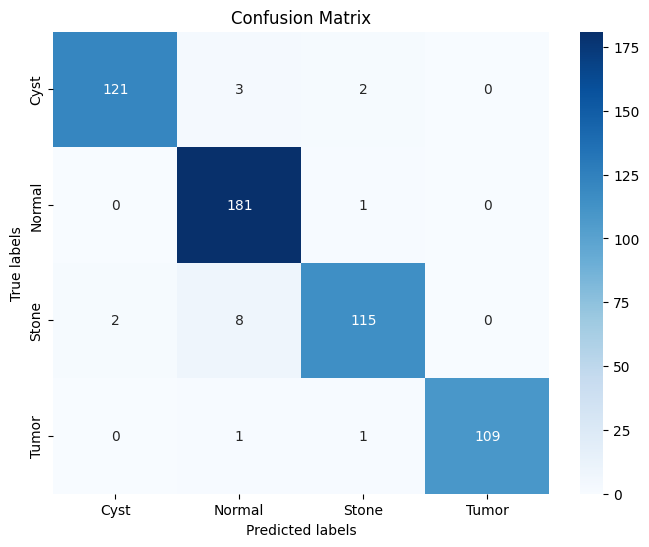

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using ELM model
predicted_labels = np.argmax(predictions_elm, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Displaying confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


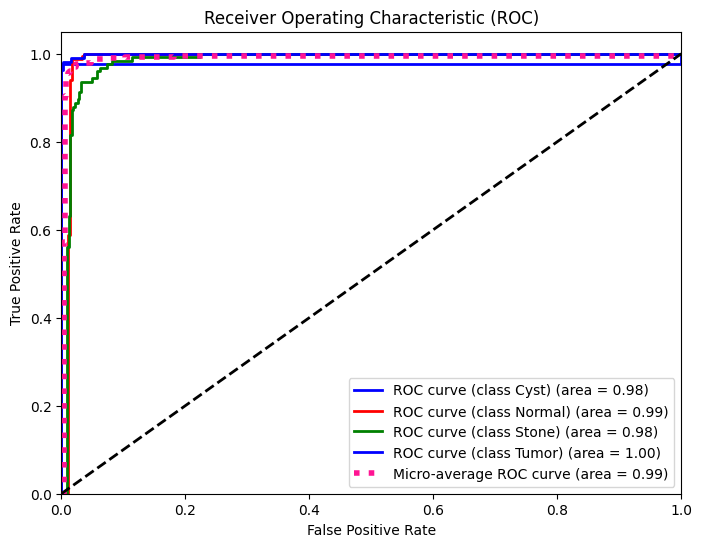

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels
binarized_true_labels = label_binarize(true_labels, classes=np.unique(true_labels))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_true_labels[:, i], predictions_elm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(binarized_true_labels.ravel(), predictions_elm.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green'])  # Change the colors as needed
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {class_names[i]}) (area = {roc_auc[i]:.2f})')

plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', lw=4, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import os

# Specify the path to the directory
directory_path = "/content/drive/MyDrive/KidneyDisease/model"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Get the model version
model_version = max([int(i) for i in os.listdir(directory_path) + [0]]) + 1

# Save the model
cnn_model.save(f"{directory_path}/{model_version}")